In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from network_revised import SequentialPerception, build_network

In [2]:
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [70]:
def chi_squared_distance(a,b):
    distance = 0
    a = a / np.sum(a)
    b = b / np.sum(b)
    for i in range(len(a)):
        if a[i]+b[i]==0:
            continue
        else:
            distance += np.square(a[i] - b[i]) / (a[i]+b[i])
    # print(a, b, distance)
    return distance

def get_loss(cues_sim, cues_emp, max_cues=18, cue_step=2):
    bins = np.arange(0, max_cues, cue_step)
    hist_sim = np.histogram(cues_sim, bins=bins)[0]
    hist_emp = np.histogram(cues_emp, bins=bins)[0]
    loss = chi_squared_distance(hist_sim, hist_emp)
    return loss

In [5]:
def sequential_trial(dP, ramp=0.1, threshold=0.4, relative=1, perception_seed=0, network_seed=0,
                 dt=0.001, cues_max=18, dt_sample=0.5, legend=False, name="sequential"):

    inputs = SequentialPerception(seed=perception_seed, dt_sample=dt_sample)
    inputs.create(dP=dP)
    net = build_network(inputs, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative)
    sim = nengo.Simulator(net, progress_bar=False)
    choice = None
    RT = None
    while choice==None:
        sim.run(dt)
        if np.any(sim.data[net.pAction][-1,:] > 0):
            choice = np.argmax(sim.data[net.pAction][-1,:])
            RT = sim.trange()[-1]
        if sim.trange()[-1] > cues_max*dt_sample:
            choice = np.argmax(sim.data[net.pValue][-1,:])
            RT = sim.trange()[-1]
    correct = 1 if choice==net.inputs.correct else 0

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((7.08, 3)))
    for a in range(2):
        axes[0].plot(sim.trange(), sim.data[net.pAccumulator][:,a], color=palette[a], label=f"Evidence {a}") 
    for a in range(2):
        axes[0].plot(sim.trange(), np.cumsum(sim.data[net.pInputs][:,a]*dt*ramp), color=palette[a], label=f"True {a}", linestyle="--") 
        axes[1].plot(sim.trange(), sim.data[net.pValue][:,a], color=palette[a], label=f"Value {a}") 
    axes[1].plot(sim.trange(), net.threshold*np.ones_like(sim.trange()), label='Threshold', color="red", linestyle=":")
    axes[0].set(ylabel=r"$\mathbf{\hat{x}}(t)$", xlabel="Time (s)", title="Evidence in Accumulator")
    axes[1].set(xlabel="Time (s)", title="Decision Criteria")
    if legend:
        axes[0].legend(loc='upper left', ncol=2)
        leg = axes[1].legend(loc='upper left')
        leg.get_texts()[net.inputs.correct].set_color("lime" if correct else "red")
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

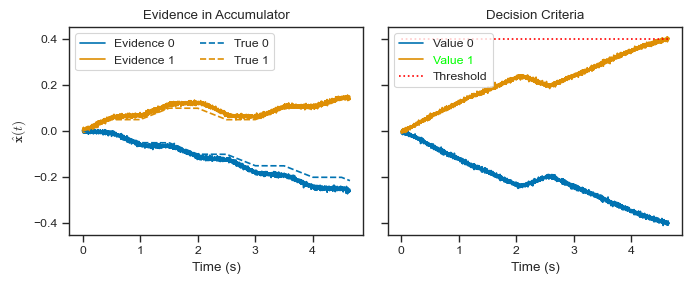

In [6]:
sequential_trial(dP=0.4, ramp=0.1, threshold=0.4, legend=True)

In [12]:
def sequential_agent(dP, ramp=0.1, threshold=0.4, relative=1, perception_seed=0, network_seed=0,
                 experiment_time=60.0, dt=0.001, cues_max=18, dt_sample=0.5, name="sequential_agent"):

    inputs = SequentialPerception(seed=perception_seed, dt_sample=dt_sample)
    dfs = []
    columns = ('agent', 'trial', 'accuracy', 'RT')
    total_time = 0
    trial = 0
    while total_time < experiment_time:
        print(f"trial {trial}")
        inputs.create(dP=dP)
        net = build_network(inputs, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative)
        sim = nengo.Simulator(net, progress_bar=False)
        choice = None
        RT = None
        while choice==None:
            sim.run(dt)
            if np.any(sim.data[net.pAction][-1,:] > 0):
                choice = np.argmax(sim.data[net.pAction][-1,:])
                RT = sim.trange()[-1]
            if sim.trange()[-1] > cues_max*dt_sample:
                choice = np.argmax(sim.data[net.pValue][-1,:])
                RT = sim.trange()[-1]
        correct = 1 if choice==net.inputs.correct else 0
        dfs.append(pd.DataFrame([['test agent', trial, 100*correct, RT]], columns=columns))
        total_time += RT
        trial += 1

    data = pd.concat(dfs, ignore_index=True)
    print(f"{trial} trials completed in {experiment_time} seconds; mean accuracy {data['accuracy'].mean()}")

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((3.5, 3)))
    sns.histplot(data=data, x="RT", stat="percent", palette=palette[0], ax=ax)
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
19 trials completed in 120.0 seconds; mean accuracy 94.73684210526316


C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_4524\3779382685.py:33: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=data, x="RT", stat="percent", palette=palette[0], ax=ax)


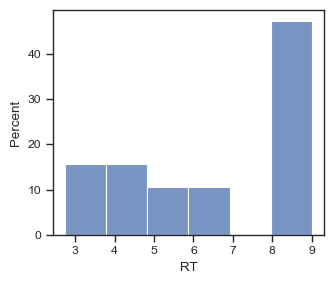

In [113]:
sequential_agent(dP=0.4, ramp=0.3, threshold=0.8, experiment_time=120.0)

trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
16 trials completed in 120.0 seconds; mean accuracy 56.25


C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_4524\3779382685.py:33: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=data, x="RT", stat="percent", palette=palette[0], ax=ax)


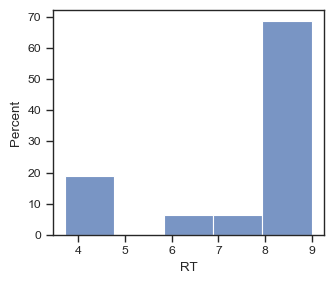

In [114]:
sequential_agent(dP=0.1, ramp=0.3, threshold=0.8, experiment_time=120.0)

In [83]:
def scan_dP(dPs=[0.4, 0.2, 0.1], ramp=0.1, threshold=0.4, relative=1, perception_seed=0, network_seed=0,
                 experiment_time=60.0, dt=0.001, cues_max=18, dt_sample=0.5, name="scan_dP", load=False):

    if not load:
        inputs = SequentialPerception(seed=perception_seed, dt_sample=dt_sample)
        dfs = []
        columns = ('type', 'id', 'dP', 'trial', 'accuracy', 'cues')
        for dP in dPs:
            inputs.create(dP=dP)
            total_time = 0
            trial = 0
            while total_time < experiment_time:
                print(f"trial {trial}, dP {dP}")
                net = build_network(inputs, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative)
                sim = nengo.Simulator(net, progress_bar=False)
                choice = None
                RT = None
                while choice==None:
                    sim.run(dt)
                    if np.any(sim.data[net.pAction][-1,:] > 0):
                        choice = np.argmax(sim.data[net.pAction][-1,:])
                        RT = sim.trange()[-1]
                    if sim.trange()[-1] > cues_max*dt_sample:
                        choice = np.argmax(sim.data[net.pValue][-1,:])
                        RT = sim.trange()[-1]
                correct = 1 if choice==net.inputs.correct else 0
                cues = int(RT/dt_sample)+1
                dfs.append(pd.DataFrame([['model', '0', dP, trial, 100*correct, cues]], columns=columns))
                total_time += RT
                trial += 1
        # print(f"{trial} trials completed in {experiment_time} seconds; mean accuracy {data['accuracy'].mean()}")
        sim = pd.concat(dfs, ignore_index=True)
        sim.to_pickle("data/one_agent.pkl")
    else:
        sim = pd.read_pickle("data/one_agent.pkl")

    emp = pd.read_pickle("data/fiedler2021_new.pkl")
    # data = pd.concat([sim, emp], ignore_index=True)    
    one_pid = emp['id'].unique()[1]
    data = pd.concat([sim, emp.query("id==@one_pid")], ignore_index=True)
    for dP in dPs:
        sim_cues = data.query("type=='model' & dP==@dP")['cues'].to_numpy()
        emp_cues = data.query("type=='human' & dP==@dP")['cues'].to_numpy()
        loss = get_loss(sim_cues, emp_cues)
        print(f"dP {dP}, loss {loss}")

    fig = sns.FacetGrid(data, row="type", col="dP", col_order=[0.4, 0.2, 0.1], palette=palette, height=1.5, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="cues", stat='percent', element="poly", bins=np.arange(0, 2*cues_max, 2), common_norm=False)
    fig.set_xlabels("Cues Sampled Per Trial")
    fig.add_legend()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

    # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((3.5, 3)))
    # sns.histplot(data=data, x="RT", stat="percent", palette=palette[0], ax=ax)
    # plt.tight_layout()
    # fig.savefig(f"plots/{name}.svg")
    # fig.savefig(f"plots/{name}.png", dpi=600)

dP 0.4, loss 0.4661768256427325
dP 0.2, loss 0.49810869967833354
dP 0.1, loss 0.535421034241789


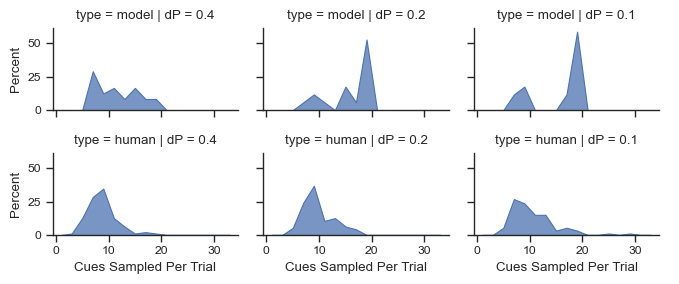

In [84]:
scan_dP(experiment_time=120.0, ramp=0.3, threshold=0.8, load=True)

In [76]:
def remake_fiedler():
    emp = pd.read_pickle("data/fiedler2021.pkl")
    dfs_emp = []
    columns = ('type', 'id', 'dP', 'trial', 'accuracy', 'cues')
    for i, pid in enumerate(emp['participant_id'].unique()):
        for dP in [0.4, 0.2, 0.1]:
            # print(f"pid {pid}, dP {dP}")
            subdata = emp.query("participant_id==@pid & delta==@dP")
            trial = 0
            for index, row in subdata.iterrows():
                dfs_emp.append(pd.DataFrame([["human", f"{i}", dP, trial, 100*row['correct'], row['cues']]], columns=columns))
                trial += 1
    new_emp = pd.concat(dfs_emp, ignore_index=True)
    new_emp.to_pickle("data/fiedler2021_new.pkl")
remake_fiedler()

In [93]:
dfs = []
columns = ('type', 'id', 'dP', 'mean cues', 'var cues', 'mean acc', 'var acc')
emp = pd.read_pickle("data/fiedler2021_new.pkl")
for pid in emp['id'].unique():
    for dP in [0.4, 0.2, 0.1]:
        subdata = emp.query("id==@pid & dP==@dP")
        mean_cues = subdata['cues'].mean()
        var_cues = subdata['cues'].std()
        mean_acc = subdata['accuracy'].mean()
        var_acc = subdata['accuracy'].std()
        dfs.append(pd.DataFrame([['human', pid, dP, mean_cues, var_cues, mean_acc, var_acc]], columns=columns))
new_emp = pd.concat(dfs, ignore_index=True)
new_emp.to_pickle("data/fiedler2021_condensed.pkl")

In [94]:
new_emp

,type,id,dP,mean cues,var cues,mean acc,var acc
0,human,0,0.4,20.708333,8.195859,91.666667,28.232985
1,human,0,0.2,21.720000,7.892613,96.000000,20.000000
2,human,0,0.1,25.360000,7.756073,88.000000,33.166248
3,human,1,0.4,8.210526,2.744025,93.684211,24.453718
4,human,1,0.2,9.284211,2.834676,77.894737,41.715723
...,...,...,...,...,...,...,...
166,human,55,0.2,11.808219,4.248063,90.410959,29.647857
167,human,55,0.1,14.121622,6.707086,72.972973,44.713080
168,human,56,0.4,12.203704,4.586196,100.000000,0.000000
169,human,56,0.2,16.370370,6.879821,98.148148,13.608276


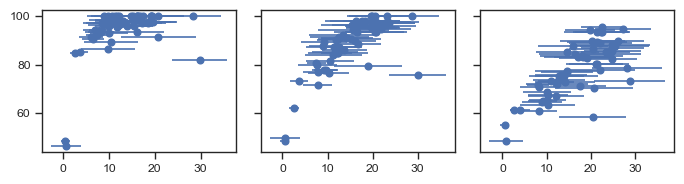

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=((7,2)))
for i, dP in enumerate([0.4, 0.2, 0.1]):
    subdata = new_emp.query("dP==@dP")
    x = subdata['mean cues'].to_numpy()
    y = subdata['mean acc'].to_numpy()
    xerr = subdata['var cues'].to_numpy()
    yerr = subdata['var acc'].to_numpy()
    axes[i].errorbar(x, y, xerr=xerr, yerr=0*yerr, fmt="o")
plt.tight_layout()

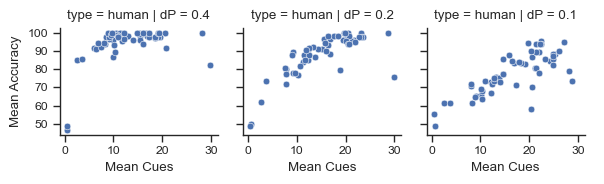

In [107]:
fig = sns.FacetGrid(new_emp, row="type", col="dP", col_order=[0.4, 0.2, 0.1], palette=palette, height=2, aspect=1)
fig.map_dataframe(sns.scatterplot, x="mean cues", y="mean acc")
fig.set_xlabels("Mean Cues")
fig.set_ylabels("Mean Accuracy")
fig.set(yticks=[50, 60, 70, 80, 90, 100])
fig.add_legend()
fig.savefig(f"plots/facet2.svg")
fig.savefig(f"plots/facet2.png", dpi=600)

In [120]:
def agent_population(nAgents, dPs=[0.4, 0.2, 0.1], ramps=[0.2, 0.4], thresholds=[0.8, 1.0], relative=1, perception_seed=0, network_seed=0,
                 experiment_time=60.0, dt=0.001, cues_max=18, dt_sample=0.5, name="agent_population", load=False):

    rng = np.random.RandomState(seed=perception_seed)
    if not load:
        dfs = []
        for agent in range(nAgents):
            ramp = rng.uniform(ramps[0], ramps[1])
            threshold = rng.uniform(thresholds[0], thresholds[1])
            inputs = SequentialPerception(seed=perception_seed, dt_sample=dt_sample)
            columns = ('type', 'id', 'dP', 'trial', 'accuracy', 'cues')
            for dP in dPs:
                inputs.create(dP=dP)
                total_time = 0
                trial = 0
                while total_time < experiment_time:
                    print(f"trial {trial}, dP {dP}, agent {agent}")
                    net = build_network(inputs, seed=agent, ramp=ramp, threshold=threshold, relative=relative)
                    sim = nengo.Simulator(net, progress_bar=False)
                    choice = None
                    RT = None
                    while choice==None:
                        sim.run(dt)
                        if np.any(sim.data[net.pAction][-1,:] > 0):
                            choice = np.argmax(sim.data[net.pAction][-1,:])
                            RT = sim.trange()[-1]
                        if sim.trange()[-1] > cues_max*dt_sample:
                            choice = np.argmax(sim.data[net.pValue][-1,:])
                            RT = sim.trange()[-1]
                    correct = 1 if choice==net.inputs.correct else 0
                    cues = int(RT/dt_sample)+1
                    dfs.append(pd.DataFrame([['model', agent, dP, trial, 100*correct, cues]], columns=columns))
                    total_time += RT
                    trial += 1
        sim = pd.concat(dfs, ignore_index=True)
        sim.to_pickle("data/agent_population.pkl")
    else:
        sim = pd.read_pickle("data/agent_population.pkl")

    dfs = []
    columns = ('type', 'id', 'dP', 'mean cues', 'var cues', 'mean acc', 'var acc')
    emp = pd.read_pickle("data/fiedler2021_new.pkl")
    combined = pd.concat([sim, emp], ignore_index=True)    
    for type in ['model', 'human']:
        for pid in combined.query("type==@type")['id'].unique():
            for dP in [0.4, 0.2, 0.1]:
                subdata = combined.query("id==@pid & dP==@dP")
                mean_cues = subdata['cues'].mean()
                var_cues = subdata['cues'].std()
                mean_acc = subdata['accuracy'].mean()
                var_acc = subdata['accuracy'].std()
                dfs.append(pd.DataFrame([[type, pid, dP, mean_cues, var_cues, mean_acc, var_acc]], columns=columns))
    new_combined = pd.concat(dfs, ignore_index=True)
    new_combined.to_pickle("data/population_combined.pkl")

    fig = sns.FacetGrid(new_combined, row="type", col="dP", col_order=[0.4, 0.2, 0.1], palette=palette, height=2, aspect=1)
    fig.map_dataframe(sns.scatterplot, x="mean cues", y="mean acc")
    fig.set_xlabels("Mean Cues")
    fig.set_ylabels("Mean Accuracy")
    fig.set(yticks=[50, 60, 70, 80, 90, 100])
    fig.add_legend()
    fig.savefig(f"plots/population_combined.svg")
    fig.savefig(f"plots/population_combined.png", dpi=600)

trial 0, dP 0.4, agent 0
trial 1, dP 0.4, agent 0
trial 2, dP 0.4, agent 0
trial 3, dP 0.4, agent 0
trial 4, dP 0.4, agent 0
trial 5, dP 0.4, agent 0
trial 6, dP 0.4, agent 0
trial 7, dP 0.4, agent 0
trial 8, dP 0.4, agent 0
trial 9, dP 0.4, agent 0
trial 10, dP 0.4, agent 0
trial 11, dP 0.4, agent 0
trial 12, dP 0.4, agent 0
trial 13, dP 0.4, agent 0
trial 14, dP 0.4, agent 0
trial 15, dP 0.4, agent 0
trial 16, dP 0.4, agent 0
trial 17, dP 0.4, agent 0
trial 18, dP 0.4, agent 0
trial 19, dP 0.4, agent 0
trial 0, dP 0.2, agent 0
trial 1, dP 0.2, agent 0
trial 2, dP 0.2, agent 0
trial 3, dP 0.2, agent 0
trial 4, dP 0.2, agent 0
trial 5, dP 0.2, agent 0
trial 6, dP 0.2, agent 0
trial 7, dP 0.2, agent 0
trial 8, dP 0.2, agent 0
trial 9, dP 0.2, agent 0
trial 10, dP 0.2, agent 0
trial 11, dP 0.2, agent 0
trial 12, dP 0.2, agent 0
trial 13, dP 0.2, agent 0
trial 14, dP 0.2, agent 0
trial 15, dP 0.2, agent 0
trial 0, dP 0.1, agent 0
trial 1, dP 0.1, agent 0
trial 2, dP 0.1, agent 0
trial 3, 

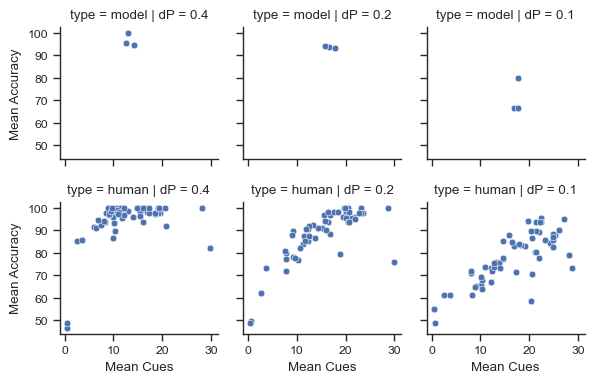

In [121]:
agent_population(nAgents=3, experiment_time=120, load=False)

trial 0, dP 0.4, agent 0
trial 1, dP 0.4, agent 0
trial 2, dP 0.4, agent 0
trial 3, dP 0.4, agent 0
trial 4, dP 0.4, agent 0
trial 5, dP 0.4, agent 0
trial 6, dP 0.4, agent 0
trial 7, dP 0.4, agent 0
trial 8, dP 0.4, agent 0
trial 9, dP 0.4, agent 0
trial 10, dP 0.4, agent 0
trial 11, dP 0.4, agent 0
trial 12, dP 0.4, agent 0
trial 13, dP 0.4, agent 0
trial 14, dP 0.4, agent 0
trial 15, dP 0.4, agent 0
trial 16, dP 0.4, agent 0
trial 17, dP 0.4, agent 0
trial 0, dP 0.2, agent 0
trial 1, dP 0.2, agent 0
trial 2, dP 0.2, agent 0
trial 3, dP 0.2, agent 0
trial 4, dP 0.2, agent 0
trial 5, dP 0.2, agent 0
trial 6, dP 0.2, agent 0
trial 7, dP 0.2, agent 0
trial 8, dP 0.2, agent 0
trial 9, dP 0.2, agent 0
trial 10, dP 0.2, agent 0
trial 11, dP 0.2, agent 0
trial 12, dP 0.2, agent 0
trial 13, dP 0.2, agent 0
trial 0, dP 0.1, agent 0
trial 1, dP 0.1, agent 0
trial 2, dP 0.1, agent 0
trial 3, dP 0.1, agent 0
trial 4, dP 0.1, agent 0
trial 5, dP 0.1, agent 0
trial 6, dP 0.1, agent 0
trial 7, dP 0

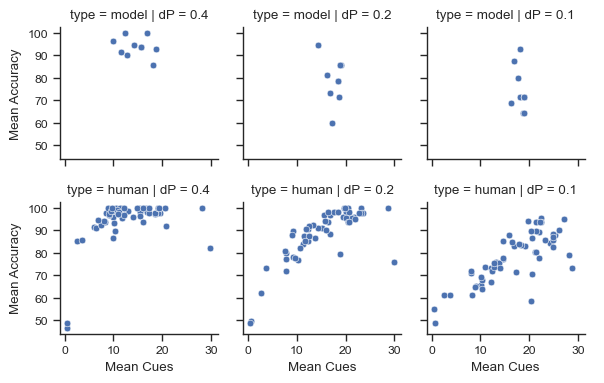

In [123]:
agent_population(nAgents=10, experiment_time=120, load=False, thresholds=[0.6, 1.2], ramps=[0.2, 0.4])